## Generate superpixel-based pseudolabels


### Overview

This is the third step for data preparation

Input: normalized images

Output: pseulabel label candidates for all the images

In [1]:
%reset
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import copy
import skimage

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import label 
import scipy.ndimage.morphology as snm
from skimage import io
import argparse
import numpy as np
import glob

import SimpleITK as sitk
import os

to01 = lambda x: (x - x.min()) / (x.max() - x.min())



**Summary**

a. Generate a mask of the patient to avoid pseudolabels of empty regions in the background

b. Generate superpixels as pseudolabels

**Configurations of pseudlabels**

```python
# default setting of minimum superpixel sizes
segs = seg_func(img[ii, ...], min_size = 400, sigma = 1)
# you can also try other configs
segs = seg_func(img[ii, ...], min_size = 100, sigma = 0.8)
```


In [2]:
DATASET_CONFIG = {'SABS':{
                    'img_bname': f'~/medical-data/ABD-CT/ABD-CT-Preprocessed/image_*.nii.gz',
                    'out_dir': '~/medical-data/ABD-CT/ABD-CT-Preprocessed/',
                    'fg_thresh': 1e-4
                    },
                  'CHAOST2':{
                      'img_bname': f'/home/user01/medical-data/norm/image_*.nii.gz',
                      'out_dir': '/home/user01/medical-data/OUT',
                      'fg_thresh': 1e-4 + 50
                    }
                 }
            

DOMAIN = 'CHAOST2'
img_bname = DATASET_CONFIG[DOMAIN]['img_bname']
imgs = glob.glob(img_bname)
out_dir = DATASET_CONFIG[DOMAIN]['out_dir']


In [3]:
imgs

['/home/user01/medical-data/norm/image_31.nii.gz',
 '/home/user01/medical-data/norm/image_37.nii.gz',
 '/home/user01/medical-data/norm/image_13.nii.gz',
 '/home/user01/medical-data/norm/image_15.nii.gz',
 '/home/user01/medical-data/norm/image_8.nii.gz',
 '/home/user01/medical-data/norm/image_3.nii.gz',
 '/home/user01/medical-data/norm/image_1.nii.gz',
 '/home/user01/medical-data/norm/image_2.nii.gz',
 '/home/user01/medical-data/norm/image_10.nii.gz',
 '/home/user01/medical-data/norm/image_38.nii.gz',
 '/home/user01/medical-data/norm/image_21.nii.gz',
 '/home/user01/medical-data/norm/image_34.nii.gz',
 '/home/user01/medical-data/norm/image_33.nii.gz',
 '/home/user01/medical-data/norm/image_39.nii.gz',
 '/home/user01/medical-data/norm/image_32.nii.gz',
 '/home/user01/medical-data/norm/image_5.nii.gz',
 '/home/user01/medical-data/norm/image_36.nii.gz',
 '/home/user01/medical-data/norm/image_22.nii.gz',
 '/home/user01/medical-data/norm/image_20.nii.gz',
 '/home/user01/medical-data/norm/ima

In [5]:
imgs = sorted(imgs, key = lambda x: int(x.split('_')[-1].split('.nii.gz')[0]) )

In [6]:
imgs

['/home/user01/medical-data/norm/image_1.nii.gz',
 '/home/user01/medical-data/norm/image_2.nii.gz',
 '/home/user01/medical-data/norm/image_3.nii.gz',
 '/home/user01/medical-data/norm/image_5.nii.gz',
 '/home/user01/medical-data/norm/image_8.nii.gz',
 '/home/user01/medical-data/norm/image_10.nii.gz',
 '/home/user01/medical-data/norm/image_13.nii.gz',
 '/home/user01/medical-data/norm/image_15.nii.gz',
 '/home/user01/medical-data/norm/image_19.nii.gz',
 '/home/user01/medical-data/norm/image_20.nii.gz',
 '/home/user01/medical-data/norm/image_21.nii.gz',
 '/home/user01/medical-data/norm/image_22.nii.gz',
 '/home/user01/medical-data/norm/image_31.nii.gz',
 '/home/user01/medical-data/norm/image_32.nii.gz',
 '/home/user01/medical-data/norm/image_33.nii.gz',
 '/home/user01/medical-data/norm/image_34.nii.gz',
 '/home/user01/medical-data/norm/image_36.nii.gz',
 '/home/user01/medical-data/norm/image_37.nii.gz',
 '/home/user01/medical-data/norm/image_38.nii.gz',
 '/home/user01/medical-data/norm/ima

In [6]:
# from skimage.segmentation import slic as skimage_slic

# # def supervox(img, **kwargs):
# #     c = skimage_slic(np.moveaxis(img, 0, -1),
# #                         n_segments=200, 
# #                         compactness=0.01, #should be low
# #                         max_num_iter=10,
# #                         sigma=2, 
# #                         spacing=None, 
# #                         multichannel=False,        # Fixed
# #                         convert2lab=None, 
# #                         enforce_connectivity=True, # Fixed
# #                         min_size_factor=0.01, #0.5
# #                         max_size_factor=5,
# #                         slic_zero=False, 
# #                         start_label=1,             # Fixed
# #                         mask=None,                 # Fixed
# #                         channel_axis=- 1)
# #     return np.moveaxis(c, -1, 0)

# # def supervox(img, **kwargs):
# #     c = skimage_slic(np.moveaxis(img, 0, -1),
# #                         n_segments=120, 
# #                         compactness=0.01, #should be low
# #                         max_num_iter=10,
# #                         sigma=2, 
# #                         spacing=None, 
# #                         multichannel=False,        # Fixed
# #                         convert2lab=None, 
# #                         enforce_connectivity=True, # Fixed
# #                         min_size_factor=0.2, #0.5
# #                         max_size_factor=5,
# #                         slic_zero=False, 
# #                         start_label=1,             # Fixed
# #                         mask=None,                 # Fixed
# #                         channel_axis=- 1)
# #     return np.moveaxis(c, -1, 0)

# def supervox(img, **kwargs):
#     c = skimage_slic(np.moveaxis(img, 0, -1),
#                         n_segments=100, 
#                         compactness=0.2, #should be low
#                         max_num_iter=10,
#                         sigma=2, 
#                         spacing=None, 
#                         multichannel=False,        # Fixed
#                         convert2lab=None, 
#                         enforce_connectivity=True, # Fixed
#                         min_size_factor=0.3, #0.5
#                         max_size_factor=5,
#                         slic_zero=False, 
#                         start_label=1,             # Fixed
#                         mask=None,                 # Fixed
#                         channel_axis=- 1)
#     return np.moveaxis(c, -1, 0)

# # thresholding the intensity values to get a binary mask of the patient
# def fg_mask2d(img_2d, thresh): # change this by your need
#     mask_map = np.float32(img_2d > thresh)
    
#     def getLargestCC(segmentation): # largest connected components
#         labels = label(segmentation)
#         assert( labels.max() != 0 ) # assume at least 1 CC
#         largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
#         return largestCC
#     if mask_map.max() < 0.999:
#         return mask_map
#     else:
#         post_mask = getLargestCC(mask_map)
#         fill_mask = snm.binary_fill_holes(post_mask)
#     return fill_mask

# # remove superpixels within the empty regions
# def superpix_masking(raw_seg2d, mask2d):
#     raw_seg2d = np.int32(raw_seg2d)
#     lbvs = np.unique(raw_seg2d)
#     max_lb = lbvs.max()
#     raw_seg2d[raw_seg2d == 0] = max_lb + 1
#     lbvs = list(lbvs)
#     lbvs.append( max_lb )
#     raw_seg2d = raw_seg2d * mask2d
#     lb_new = 1
#     out_seg2d = np.zeros(raw_seg2d.shape)
#     for lbv in lbvs:
#         if lbv == 0:
#             continue
#         else:
#             out_seg2d[raw_seg2d == lbv] = lb_new
#             lb_new += 1
    
#     return out_seg2d
            
# def superpix_wrapper(img, ns, c, verbose = False, fg_thresh = 1e-4):
#     raw_seg = supervox(img, n_segments=ns, compactness=c)
#     fg_mask_vol = np.zeros(raw_seg.shape)
#     processed_seg_vol = np.zeros(raw_seg.shape)
#     for ii in range(raw_seg.shape[0]):
#         if verbose:
#             print("doing {} slice".format(ii))
#         _fgm = fg_mask2d(img[ii, ...], fg_thresh )
#         _out_seg = superpix_masking(raw_seg[ii, ...], _fgm)
#         fg_mask_vol[ii] = _fgm
#         processed_seg_vol[ii] = _out_seg
#     return fg_mask_vol, processed_seg_vol
        
# # copy spacing and orientation info between sitk objects
# def copy_info(src, dst):
#     dst.SetSpacing(src.GetSpacing())
#     dst.SetOrigin(src.GetOrigin())
#     dst.SetDirection(src.GetDirection())
#     # dst.CopyInfomation(src)
#     return dst


# def strip_(img, lb):
#     img = np.int32(img)
#     if isinstance(lb, float):
#         lb = int(lb)
#         return np.float32(img == lb) * float(lb)
#     elif isinstance(lb, list):
#         out = np.zeros(img.shape)
#         for _lb in lb:
#             out += np.float32(img == int(_lb)) * float(_lb)
            
#         return out
#     else:
#         raise Exception

In [7]:
MODE = 'MIDDLE' # minimum size of pesudolabels. 'MIDDLE' is the default setting

# wrapper for process 3d image in 2d
def superpix_vol(img, method = 'fezlen', **kwargs):
    """
    loop through the entire volume
    assuming image with axis z, x, y
    """
    if method =='fezlen':
        seg_func = skimage.segmentation.felzenszwalb
    else:
        raise NotImplementedError
        
    out_vol = np.zeros(img.shape)
    for ii in range(img.shape[0]):
        if MODE == 'MIDDLE':
            segs = seg_func(img[ii, ...], min_size = 400, sigma = 1)
        else:
            raise NotImplementedError
        out_vol[ii, ...] = segs
        
    return out_vol

# thresholding the intensity values to get a binary mask of the patient
def fg_mask2d(img_2d, thresh): # change this by your need
    mask_map = np.float32(img_2d > thresh)
    
    def getLargestCC(segmentation): # largest connected components
        labels = label(segmentation)
        assert( labels.max() != 0 ) # assume at least 1 CC
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
        return largestCC
    if mask_map.max() < 0.999:
        return mask_map
    else:
        post_mask = getLargestCC(mask_map)
        fill_mask = snm.binary_fill_holes(post_mask)
    return fill_mask

# remove superpixels within the empty regions
def superpix_masking(raw_seg2d, mask2d):
    raw_seg2d = np.int32(raw_seg2d)
    lbvs = np.unique(raw_seg2d)
    max_lb = lbvs.max()
    raw_seg2d[raw_seg2d == 0] = max_lb + 1
    lbvs = list(lbvs)
    lbvs.append( max_lb )
    raw_seg2d = raw_seg2d * mask2d
    lb_new = 1
    out_seg2d = np.zeros(raw_seg2d.shape)
    for lbv in lbvs:
        if lbv == 0:
            continue
        else:
            out_seg2d[raw_seg2d == lbv] = lb_new
            lb_new += 1
    
    return out_seg2d
            
def superpix_wrapper(img, verbose = False, fg_thresh = 1e-4):
    raw_seg = superpix_vol(img)
    fg_mask_vol = np.zeros(raw_seg.shape)
    processed_seg_vol = np.zeros(raw_seg.shape)
    for ii in range(raw_seg.shape[0]):
        if verbose:
            print("doing {} slice".format(ii))
        _fgm = fg_mask2d(img[ii, ...], fg_thresh )
        _out_seg = superpix_masking(raw_seg[ii, ...], _fgm)
        fg_mask_vol[ii] = _fgm
        processed_seg_vol[ii] = _out_seg
    return fg_mask_vol, processed_seg_vol
        
# copy spacing and orientation info between sitk objects
def copy_info(src, dst):
    dst.SetSpacing(src.GetSpacing())
    dst.SetOrigin(src.GetOrigin())
    dst.SetDirection(src.GetDirection())
    # dst.CopyInfomation(src)
    return dst


def strip_(img, lb):
    img = np.int32(img)
    if isinstance(lb, float):
        lb = int(lb)
        return np.float32(img == lb) * float(lb)
    elif isinstance(lb, list):
        out = np.zeros(img.shape)
        for _lb in lb:
            out += np.float32(img == int(_lb)) * float(_lb)
            
        return out
    else:
        raise Exception

In [9]:
DATASET_CONFIG[DOMAIN]['fg_thresh']

50.0001

In [11]:
# Generate pseudolabels for every image and save them
for img_fid in imgs:
# img_fid = imgs[0]

    idx = os.path.basename(img_fid).split("_")[-1].split(".nii.gz")[0]
    im_obj = sitk.ReadImage(img_fid)

    out_fg, out_seg = superpix_wrapper(sitk.GetArrayFromImage(im_obj), 100, 0.01, fg_thresh = DATASET_CONFIG[DOMAIN]['fg_thresh'] )
    out_fg_o = sitk.GetImageFromArray(out_fg ) 
    out_seg_o = sitk.GetImageFromArray(out_seg )

    out_fg_o = copy_info(im_obj, out_fg_o)
    out_seg_o = copy_info(im_obj, out_seg_o)
    seg_fid = os.path.join(out_dir, f'supervox_NEW_{idx}.nii.gz')
    msk_fid = os.path.join(out_dir, f'fgmaskvox_{idx}.nii.gz')
    sitk.WriteImage(out_fg_o, msk_fid)
    sitk.WriteImage(out_seg_o, seg_fid)
    print(f'image with id {idx} has finished')


/tmp/ipykernel_852548/2814972887.py:37: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  fill_mask = snm.binary_fill_holes(post_mask)


image with id 1 has finished
image with id 2 has finished
image with id 3 has finished
image with id 5 has finished
image with id 8 has finished
image with id 10 has finished
image with id 13 has finished
image with id 15 has finished
image with id 19 has finished
image with id 20 has finished
image with id 21 has finished
image with id 22 has finished
image with id 31 has finished
image with id 32 has finished
image with id 33 has finished
image with id 34 has finished
image with id 36 has finished
image with id 37 has finished
image with id 38 has finished
image with id 39 has finished


In [12]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

0.0 910.0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 1

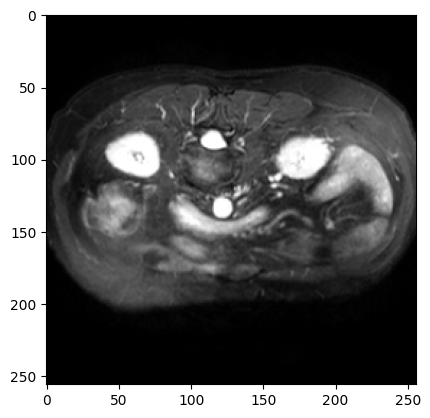

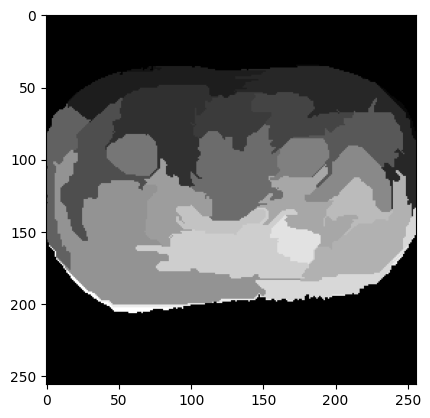

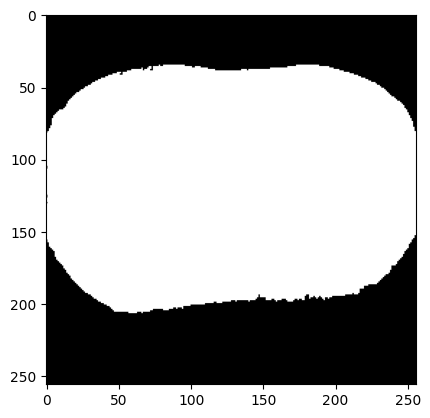

In [16]:
patient_num = 20
slice_num = 7

vol_path = f'/home/user01/medical-data/norm/image_{patient_num}.nii.gz'
spx_path = f'/home/user01/medical-data/norm/superpix-MIDDLE_{patient_num}.nii.gz'
fgm_path = f'/home/user01/medical-data/norm/fgmask_{patient_num}.nii.gz'

vol = sitk.ReadImage(vol_path)
vol = sitk.GetArrayFromImage(vol) 

spx = sitk.ReadImage(spx_path)
spx = sitk.GetArrayFromImage(spx) 

fgm = sitk.ReadImage(fgm_path)
fgm = sitk.GetArrayFromImage(fgm) 


print(vol.min(), vol.max())
print(np.unique(vol))
print(spx.min(), spx.max())
print(np.unique(spx))
print(fgm.min(), fgm.max())
print(np.unique(fgm))


plt.imshow(vol[slice_num, ...], cmap='gray')
plt.show()
plt.imshow(spx[slice_num, ...], cmap='gray')
plt.show()
plt.imshow(fgm[slice_num, ...], cmap='gray')
plt.show()
